# Import Data
- Unzip Images
- Unzip annotations
- Display contents of both sets of annotations
- Figure out how to convert to coco format
- Subchip images (I think I already have a function for that?)
- 

In [1]:
import os
cwd = os.getcwd()
os.listdir(cwd), cwd

(['.ipynb_checkpoints',
  'chip_DOTA.ipynb',
  'classes.names',
  'COCO.json',
  'coco_help.py',
  'COCO_to_YOLO.ipynb',
  'DOTA.ipynb',
  'train',
  'val_1000',
  '__pycache__'],
 'C:\\Users\\knjoh\\Documents\\DOTA')

In [2]:
from matplotlib import pyplot as plt
from matplotlib import patches

In [3]:
def dota_coco_images(image_folder):
    images = os.listdir(image_folder)
    images.sort()
    coco_images = []
    image_count = 0
    for i in images:
        im_path = image_folder + i
        img = plt.imread(im_path)
        h = img.shape[0]
        w = img.shape[1]
        id = int(i.split('.')[0].replace('P',''))
        coco = {"id": id, 
                "width": w, 
                "height": h, 
                "file_name": i, 
                "license": False, 
                "gsd": False}
        coco_images.append(coco)
        image_count += 1
        if image_count % 50 == 0:
            print(f'{image_count}/{len(images)} images processed')
    return coco_images

In [4]:
def get_im_from_id(im_id, coco_images):
    '''
    Given list of COCO image descriptions and an id return the COCO image description with that ID
    '''
    for i in coco_images:
        if i['id'] == im_id:
            return i
    return None

In [5]:
def get_make_coco_cat(cat_tag, cat_id, coco_categories):
    '''
    cat_tag: string name of current category
    cat_id: int id of highest category in current categories
    coco_categories: partially populated coco style categories list

    purpose: return categrory id for current tag, creating it if necessary
    '''
    # First, check to see if the category is already in the list
    for c in coco_categories:
        if c['name'] == cat_tag:
            ann_cat_id = c['id']
            return ann_cat_id, cat_id, coco_categories

    # If not, make a new category
    new_cat = {
              "id": cat_id, 
               "name": cat_tag, 
               "supercategory": "None"
              }
    coco_categories.append(new_cat) # add it to the full list
    ann_cat_id = cat_id
    cat_id += 1

    return ann_cat_id, cat_id, coco_categories

In [6]:
def coco_anns_categories(coco_images, ann_folder):

    # list all the files in the annotations folder
    dota_anns = os.listdir(ann_folder)

    # initialize key variables
    ann_id = 0
    coco_anns = []
    cat_id = 1
    coco_categories = []

    # Process each image's annotation file
    for a in dota_anns:
        # read annotation file
        with open(ann_folder + a, 'r') as f:
            text = f.readlines()
        
        im_id = int(a.split('.')[0].replace('P',''))

        # Process all the object labels
        for data in text[2:]:
            [x1,y1, x2, y2, x3, y3, x4, y4, c, difficult] = data.replace('\n','').split(' ')
            coords = [x1,y1, x2, y2, x3, y3, x4, y4]
            coords = [float(c) for c in coords]
            [x1,y1, x2, y2, x3, y3, x4, y4] = coords
            # Create bbox
            xmin = min([x1,x2,x3,x4])
            xmax = max([x1,x2,x3,x4])
            w = xmax-xmin
            ymin = min([y1,y2,y3,y4])
            ymax = max([y1,y2,y3,y4])
            h = ymax-ymin
            bbox = [xmin, ymin, w, h]
            # calculate area of annotation box
            area = float(w*h)

            # process category
            ann_cat_id, cat_id, coco_categories = get_make_coco_cat(c, cat_id, coco_categories)

            coco_ann = {"id": ann_id, 
                        "image_id": im_id, 
                        "category_id": ann_cat_id,  
                        "area": area, 
                        "bbox": bbox, 
                        "iscrowd": 0,
                        "difficult": int(difficult)
                        }
            coco_anns.append(coco_ann)
            ann_id += 1

    return coco_anns, coco_categories

In [7]:
def get_coco_license_update_images(coco_images, ann_folder_full):
    new_coco_images = []
    licenses = []
    license_id = 0

    for i in coco_images:
        # Get name of annotation file with gsd and image source information
        im_anns = ann_folder_full + i['file_name'].replace('.png', '.txt')
        # Open this file
        with open(im_anns, 'r') as f:
            data = f.readlines()
        data = [d.replace('\n', '') for d in data]

        # Get current image's gsd
        try:
            im_gsd = data[1].split(':')[1]
            if im_gsd != 'null':
                i['gsd'] = float(im_gsd)
            else:
                i['gsd'] = None
        except:
            print(im_anns)
        license_tag = data[0].replace('imagesource:','')
        for l in licenses:
            if l['name'] == license_tag:
                i['license'] = l['id']
        if i['license'] == False:
            i['license'] = license_id
            new_license = {
            "id": license_id, 
            "name": license_tag, 
            "url": None,
            }
            licenses.append(new_license)
            license_id += 1
        new_coco_images.append(i)
    return licenses, new_coco_images

In [8]:
import json

In [9]:
def dota_to_coco(im_folder, ann_folder, ann_folder_full, version = '1.0'):
    coco_info = {
                "year": 2018, 
                 "version": version, 
                 "description": 'To advance object detection research in Earth Vision, also known as Earth Observation and Remote Sensing, we introduce a large-scale Dataset for Object deTection in Aerial images (DOTA). To this end, we collect 2806 aerial images from different sensors and platforms. Each image is of the size about 4000-by-4000 pixels and contains objects exhibiting a wide variety of scales, orientations, and shapes. These DOTA images are then annotated by experts in aerial image interpretation using 15 common object categories. The fully annotated DOTA images contains 188,282 instances.', 
                 "contributor": 'Gui-Song Xia, Xiang Bai, Jian Ding, Zhen Zhu, Serge Belongie, Jiebo Luo, Mihai Datcu, Marcello Pelillo, Liangpei Zhang.', 
                 "url": 'https://captain-whu.github.io/DOTA/index.html'
                }
    coco_images = dota_coco_images(im_folder)
    print('Images processed')
    coco_anns, coco_categories = coco_anns_categories(coco_images, ann_folder)
    coco_licenses, coco_images = get_coco_license_update_images(coco_images, ann_folder_full)

    full_coco = {
        'info' : coco_info,
        'licenses': coco_licenses,
        'images': coco_images,
        'annotations': coco_anns,
        'categories': coco_categories
    }

    parent_folder = '/'.join(im_folder.split('/')[:-2]) + '/'

    output_json = parent_folder + 'COCO.json'

    with open(output_json, 'w') as f:
        json.dump(full_coco, f)

    return output_json


In [10]:
import os

im_folder = 'C:/Users/knjoh/Documents/DOTA/train/images/'
images = os.listdir(im_folder)

label_folder = 'C:/Users/knjoh/Documents/DOTA/train/trainset_reclabelTxt/'
labels = os.listdir(label_folder)

len(images), len(labels)

(1411, 1411)

In [11]:
cwd = 'C:/Users/knjoh/Documents/DOTA/'

In [12]:
version = '1.0'
im_folder = cwd + 'train/images/'
ann_folder = cwd + 'train/trainset_reclabelTxt/'
ann_folder_full = cwd + 'train/labels2/'
# new_json = dota_to_coco(im_folder, ann_folder, ann_folder_full, version = '1.0')

In [14]:
anns_full = os.listdir(ann_folder_full)
test_anns = anns_full[0]
test_anns

'P0000.txt'

In [25]:
new_json

'C:/Users/knjoh/Documents/DOTA/val/COCO.json'

In [28]:
from coco_help import display_random_ims

<Figure size 432x288 with 0 Axes>

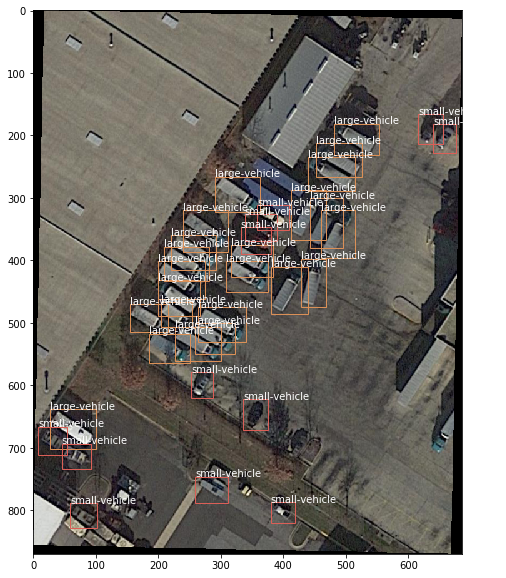

<Figure size 432x288 with 0 Axes>

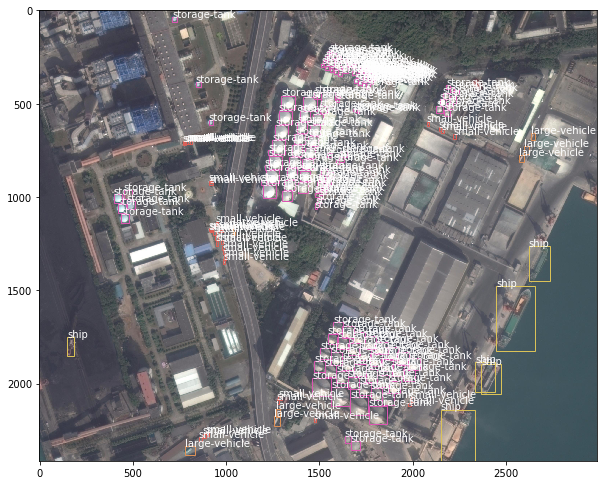

<Figure size 432x288 with 0 Axes>

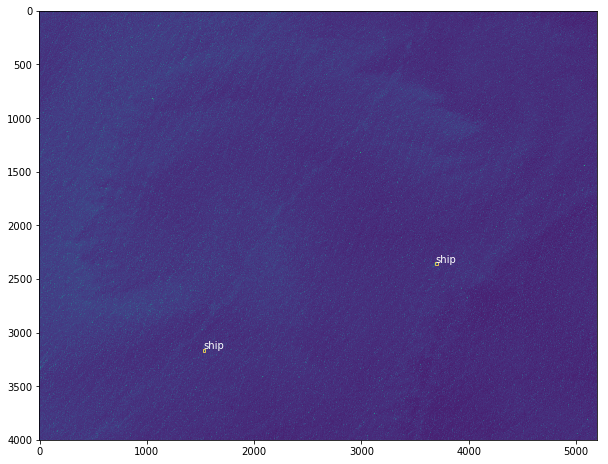

<Figure size 432x288 with 0 Axes>

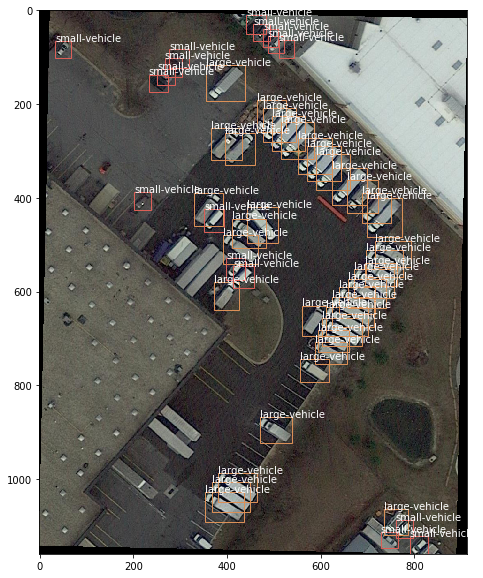

<Figure size 432x288 with 0 Axes>

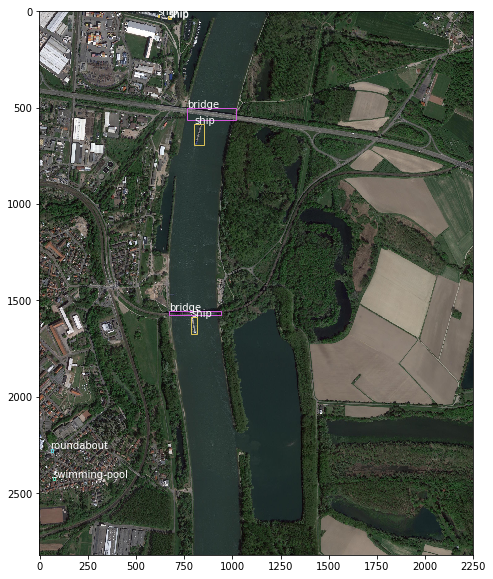

In [29]:
display_random_ims(5, new_json, im_folder, (10,10))